In [1]:
import numpy as np
import math
import xarray as xr
from scipy.stats import genextreme
import re
import datetime
import matplotlib.pyplot as plt # Assumed installed for example plot
from scipy.spatial.distance import cdist
from GEV import * 
from utils import *

Data Generation functions : Independant GRID

In [2]:
def create_independent_gev_grid(loc, scale, shape,
                                num_x=5, num_y=5, num_t=5):
    """
    Generates an xarray.Dataset with independent GEV samples at each point.

    Each value in the grid (x, y, t) is drawn independently from the same
    GEV(loc, scale, shape) distribution.

    Args:
        loc (float): The location parameter (mu) of the GEV distribution.
        scale (float): The scale parameter (sigma > 0) of the GEV distribution.
        shape (float): The shape parameter (xi) of the GEV distribution.
                       Note: Internally uses c = -shape for scipy.stats.genextreme.
                       shape < 0 (c > 0) => Weibull type (bounded above)
                       shape = 0 (c = 0) => Gumbel type
                       shape > 0 (c < 0) => Fréchet type (heavy tail)
        num_x (int): Number of points along the x dimension. Default is 5.
        num_y (int): Number of points along the y dimension. Default is 5.
        num_t (int): Number of points along the t dimension. Default is 5.

    Returns:
        xarray.Dataset: An xarray Dataset with dimensions ('x', 'y', 't')
                        and a single data variable 'extreme_value' containing
                        independent GEV samples.

    Raises:
        ValueError: If the scale parameter is not positive.
    """
    # --- Input Validation ---
    if scale <= 0:
        raise ValueError("Scale parameter (sigma) must be positive.")

    # --- Define Coordinates ---
    x_coords = np.arange(num_x)
    y_coords = np.arange(num_y)
    t_coords = np.arange(num_t)

    # --- Generate GEV Data ---
    total_values = num_x * num_y * num_t
    # Generate independent samples using the specified parameters
    # Note: Using c = -shape consistent with user input convention
    gev_data_flat = genextreme.rvs(c=-shape, loc=loc, scale=scale, size=total_values)
    gev_data_3d = gev_data_flat.reshape(num_x, num_y, num_t)

    # --- Create xarray DataArray ---
    data_variable = xr.DataArray(
        data=gev_data_3d,
        coords={'lon': x_coords, 'lat': y_coords, 'time': t_coords},
        dims=['lon', 'lat', 'time'],
        name='extreme_value',
        attrs={
            'description': 'Independent synthetic data generated from a GEV distribution.',
            'units': 'unitless',
            'location': loc,
            'scale': scale,
            'shape': shape, # Store the input shape parameter (xi)
        }
    )
    # --- Create xarray Dataset ---
    dataset = xr.Dataset({'extreme_value': data_variable})
    dataset.attrs['creation_timestamp'] = datetime.datetime.now().isoformat()
    dataset.attrs['source'] = 'Generated by create_independent_gev_grid'
    dataset.attrs['grid_type'] = 'dimensionless integer coordinates'
    dataset.attrs['dependencies'] = 'Identically distributed, independent samples'

    return dataset

Data Generation functions : Dependant GRID

In [3]:
def _validate_trend_function(trend_func_str, param_name):
    """Helper function to validate a trend function string."""
    if not isinstance(trend_func_str, str):
        raise TypeError(f"{param_name}_trend_func must be a string, got {type(trend_func_str)}.")

    # Basic character check (allows np. prefix)
    allowed_pattern = r'^[xy\d\+\-\*\/\(\)\.\*\*npcosinlgqt]*$'
    if not re.match(allowed_pattern, trend_func_str.replace(' ', '')):
         raise ValueError(
            f"Invalid characters in {param_name}_trend_func. Use only 'x', 'y', 't', numbers, "
            "operators (+, -, *, /, **), parentheses, '.', and allowed 'np.' functions "
            "(sin, cos, exp, log, log10, sqrt)."
        )
    # Check for balanced parentheses
    if trend_func_str.count('(') != trend_func_str.count(')'):
        raise ValueError(f"Unbalanced parentheses in {param_name}_trend_func.")

    # Check for disallowed numpy function calls (basic check)
    allowed_numpy_funcs_list = ['sin', 'cos', 'exp', 'log', 'log10', 'sqrt'] # Keep this list updated
    potential_np_calls = re.findall(r'np\.(\w+)', trend_func_str)
    for func_name in potential_np_calls:
        if func_name not in allowed_numpy_funcs_list:
             raise NameError(
                 f"Disallowed numpy function/attribute used in {param_name}_trend_func: np.{func_name}. "
                 f"Allowed functions: {allowed_numpy_funcs_list}"
             )

def _evaluate_parameter(param_name, base_value, trend_func_str, local_namespace, expected_shape):
    """
    Helper function to calculate a potentially non-stationary parameter array.

    Args:
        param_name (str): Name of the parameter ('loc', 'scale', 'shape').
        base_value (float): The base value for the parameter.
        trend_func_str (str or None): The string defining the trend function, or None.
        local_namespace (dict): Namespace for eval() containing x, y, t grids and np.
        expected_shape (tuple): The target shape of the output array.

    Returns:
        np.ndarray: Array of parameter values with the expected_shape.
    """
    if trend_func_str is None:
        # No trend function provided, use the constant base value
        return np.full(expected_shape, float(base_value))
    else:
        # Validate the trend function string before evaluation
        _validate_trend_function(trend_func_str, param_name)

        try:
            # Evaluate the trend function string
            # The result represents the *variation* or trend component
            trend_values = eval(trend_func_str, {"__builtins__": None}, local_namespace)

            # Add the base value to the trend component
            param_xyt = base_value + trend_values

            # Validate the shape of the result
            if not isinstance(param_xyt, np.ndarray) or param_xyt.shape != expected_shape:
                # Handle scalar results from eval (e.g., trend_func_str is just a number string)
                if np.isscalar(param_xyt):
                    param_xyt = np.full(expected_shape, float(param_xyt))
                else:
                    raise ValueError(
                        f"The {param_name}_trend_func '{trend_func_str}' did not produce the correct shape "
                        f"{expected_shape}. Resulting shape was {getattr(param_xyt, 'shape', type(param_xyt))}."
                    )
            return param_xyt

        except NameError as e:
            raise NameError(f"Invalid variable or function used in {param_name}_trend_func: {e}. Ensure 'np.' prefix for numpy funcs.") from e
        except SyntaxError as e:
            raise SyntaxError(f"Syntax error in {param_name}_trend_func: {e}") from e
        except TypeError as e:
            raise TypeError(f"Type error during {param_name}_trend_func evaluation: {e}") from e
        except Exception as e:
            raise ValueError(f"Error evaluating {param_name}_trend_func '{trend_func_str}': {e}") from e


def create_gev_nonstationary(loc=0.0, scale=1.0, shape=0.0,
                             loc_trend_func=None, scale_trend_func=None, shape_trend_func=None,
                             num_x=50, num_y=50, num_t=5, # Increased defaults for better viz
                             seed=0):
    """
    Generates GEV data with potentially non-stationary location, scale, and shape parameters
    varying as functions of normalized spatial coordinates (x, y) and time index (t).

    Coordinates:
        - x: Runs from 0 to 1 along the 'lon' dimension.
        - y: Runs from 0 to 1 along the 'lat' dimension.
        - t: Runs from 0 to num_t-1 along the 'time' dimension.

    Each parameter (loc, scale, shape) is calculated as:
    param(x, y, t) = base_param + trend_function(x, y, t)
    If the corresponding trend_function string is None, the parameter is constant (base_param).

    Args:
        loc (float): Base value for the location parameter (mu). Default is 0.0.
        scale (float): Base value for the scale parameter (sigma). Must be > 0 if scale_trend_func is None. Default is 1.0.
        shape (float): Base value for the shape parameter (xi). Default is 0.0.
        loc_trend_func (str, optional): Python expression string for location trend (added to base loc).
            Variables available: 'x', 'y', 't' (numpy meshgrids), 'np' (numpy), 'math', 'pi'. Defaults to None.
        scale_trend_func (str, optional): Python expression string for scale trend (added to base scale).
            Resulting scale must always be > 0. Defaults to None.
        shape_trend_func (str, optional): Python expression string for shape trend (added to base shape). Defaults to None.
        num_x (int): Number of points along the x dimension ('lon'). Default is 50.
        num_y (int): Number of points along the y dimension ('lat'). Default is 50.
        num_t (int): Number of points along the t dimension ('time'). Default is 5.
        seed (int): Seed for the random number generator used for GEV sampling. Default is 0.

    Returns:
        xarray.Dataset: An xarray Dataset containing GEV samples ('extreme_value')
                          and the calculated parameters ('location', 'scale', 'shape')
                          with potentially varying parameters. Base values and trend
                          functions used are stored as attributes.

    Raises:
        ValueError: If base scale <= 0 (and no trend func), if calculated scale <= 0,
                    or if a trend_function string is invalid or unsafe.
        NameError: If a trend_function uses invalid variables or functions.
        SyntaxError: If a trend_function has invalid syntax.

    **Security Warning:** This function uses `eval()` to interpret the trend function strings.
    Only use trusted strings, as malicious code could potentially be executed.

    **Example Trend Functions (`loc_trend_func` shown, applies similarly to others):**

    * **Nothing (Random points everywhere):**
        `loc_trend_func = None` (Parameters are constant, GEV samples are random)

    * **Linear Isotropic:**
        `loc_trend_func = '0.5 * (x + y)'` (Increases equally with x and y)

    * **Linear Non-Isotropic:**
        `loc_trend_func = '0.2 * x + 0.8 * y'` (Increases more steeply with y than x)

    * **Wave-like:**
        `loc_trend_func = 'np.sin(4 * pi * x) * np.cos(2 * pi * y)'` (Spatial wave pattern)

    * **Circular (Gaussian Peak/Blob):**
        `loc_trend_func = '2.0 * np.exp(-10 * ((x - 0.5)**2 + (y - 0.5)**2))'` (Peak at center)

    * **Circular (Distance-based):**
        `loc_trend_func = '-1.5 * np.sqrt((x - 0.5)**2 + (y - 0.5)**2)'` (Decreases away from center)

    * **Time Trend:**
        `loc_trend_func = '0.1 * t'` (Increases linearly with time)

    * **Combined Space-Time Trend:**
        `loc_trend_func = '(0.5 * x) + (0.05 * t)'` (Increases with x and time)
    """
    # --- Basic Input Validation ---
    if scale_trend_func is None and scale <= 0:
        raise ValueError("Base scale parameter (sigma) must be positive if scale_trend_func is not provided.")

    # --- Define Coordinates (Normalized x, y; Integer t) ---
    x_coords = np.linspace(0, 1, num_x)
    y_coords = np.linspace(0, 1, num_y)
    t_coords = np.arange(num_t)
    expected_shape = (num_x, num_y, num_t)

    # --- Create meshgrids for x, y, t ---
    # Use 'ij' indexing so shape matches (num_x, num_y, num_t)
    x_grid, y_grid, t_grid = np.meshgrid(x_coords, y_coords, t_coords, indexing='ij')

    # --- Prepare Safe Namespace for Eval ---
    # WARNING: Using eval is a security risk if trend functions come from untrusted sources.
    local_namespace = {
        'x': x_grid,
        'y': y_grid,
        't': t_grid,
        'np': np,         # Provide numpy access
        'math': math,       # Provide math module access
        'pi': math.pi     # Provide pi constant
        # Add other safe functions/constants as needed
    }

    # --- Helper function to evaluate a single parameter ---
    def _calculate_parameter(param_name, base_value, trend_func_str, namespace):
        if trend_func_str is None:
            # No trend, use constant base value
            return np.full(expected_shape, base_value)
        else:
            # Evaluate the trend function string
            try:
                # SECURITY WARNING: eval() is used here. Ensure trend_func_str is safe!
                warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",
                              UserWarning) # Shorten long strings for warning
                # Create a copy of the namespace for eval to avoid cross-contamination
                eval_namespace = {'__builtins__': {}} # Restrict builtins for slight safety increase
                eval_namespace.update(namespace)

                trend_result = eval(trend_func_str, {"np": np, "math": math}, eval_namespace) # Pass globals explicitly

                # Ensure result is broadcastable to the expected shape
                # This allows functions like '0.1 * t' which might initially have shape (num_t,)
                # Or constants like '0.5'
                if not isinstance(trend_result, np.ndarray) or trend_result.shape != expected_shape:
                     # Attempt broadcasting scalar or partially defined array
                     try:
                         trend_result_broadcast = np.broadcast_to(trend_result, expected_shape)
                     except ValueError as e:
                          raise ValueError(f"Trend function for '{param_name}' produced "
                                           f"result with shape {np.shape(trend_result)} "
                                           f"which cannot be broadcast to target shape {expected_shape}. "
                                           f"Original error: {e}") from e
                else:
                    trend_result_broadcast = trend_result

                # Add trend to the base value
                param_array = base_value + trend_result_broadcast

                if not np.isscalar(param_array) and param_array.shape != expected_shape:
                     raise ValueError(f"Internal error: Final parameter array for '{param_name}' "
                                      f"has unexpected shape {param_array.shape}. Expected {expected_shape}.")

                return param_array.astype(float) # Ensure float type

            except (SyntaxError, NameError, TypeError, KeyError) as e:
                raise ValueError(f"Error evaluating trend function for '{param_name}': '{trend_func_str}'. "
                                 f"Ensure expression is valid Python, uses only allowed variables "
                                 f"(x, y, t, np, math, pi), and functions. Original error: {e}") from e
            except Exception as e:
                 raise ValueError(f"An unexpected error occurred evaluating trend function for '{param_name}': {e}") from e


    # --- Calculate Spatially and Temporally Varying Parameters ---
    loc_xyt = _calculate_parameter('loc', loc, loc_trend_func, local_namespace)
    scale_xyt = _calculate_parameter('scale', scale, scale_trend_func, local_namespace)
    shape_xyt = _calculate_parameter('shape', shape, shape_trend_func, local_namespace)

    # --- Validate Calculated Scale Parameter ---
    if np.any(scale_xyt <= 0):
        min_scale = np.min(scale_xyt)
        raise ValueError(f"Calculated scale parameter must be positive everywhere, but found "
                         f"minimum value {min_scale:.4f}. Check base 'scale' ({scale}) and "
                         f"'scale_trend_func' ('{scale_trend_func}').")

    # --- Generate GEV Data ---
    # Use the calculated parameter arrays. Note: scipy.stats.genextreme uses c = -shape.
    rng = np.random.default_rng(seed)
    gev_data_3d = genextreme.rvs(c=-shape_xyt, loc=loc_xyt, scale=scale_xyt,
                                 size=expected_shape, random_state=rng)

    # --- Create xarray DataArrays for parameters and data ---
    coords_dict = {'lon': x_coords, 'lat': y_coords, 'time': t_coords}
    dims_list = ['lon', 'lat', 'time']

    data_var = xr.DataArray(
        data=gev_data_3d,
        coords=coords_dict,
        dims=dims_list,
        name='extreme_value',
        attrs={
            'description': 'Synthetic GEV samples.',
            'units': 'unitless', # Adjust if applicable
            'gev_rng_seed': seed,
        }
    )
    loc_var = xr.DataArray(
        data=loc_xyt, coords=coords_dict, dims=dims_list, name='location',
        attrs={'description': 'GEV location parameter (mu)', 'base_value': loc, 'trend_function': str(loc_trend_func)}
    )
    scale_var = xr.DataArray(
        data=scale_xyt, coords=coords_dict, dims=dims_list, name='scale',
         attrs={'description': 'GEV scale parameter (sigma)', 'base_value': scale, 'trend_function': str(scale_trend_func)}
    )
    shape_var = xr.DataArray(
        data=shape_xyt, coords=coords_dict, dims=dims_list, name='shape',
        attrs={'description': 'GEV shape parameter (xi)', 'base_value': shape, 'trend_function': str(shape_trend_func)}
    )

    # --- Create xarray Dataset ---
    dataset = xr.Dataset({
        'extreme_value': data_var,
        'location': loc_var,
        'scale': scale_var,
        'shape': shape_var
        })

    dataset.attrs['creation_timestamp'] = datetime.datetime.now(datetime.timezone.utc).isoformat()
    dataset.attrs['source'] = 'Generated by create_gev_nonstationary'
    dataset.attrs['grid_type'] = 'normalized spatial coordinates (0-1), integer time index'
    dataset.attrs['dependencies'] = 'Spatio-temporal dependence via user-defined trend functions for loc, scale, and shape.'
    dataset.attrs['eval_security_warning'] = 'Trend functions evaluated using eval(). Use with caution.'

    return dataset


Data visualization functions

In [4]:
def plot_time(
    data: Union[xr.Dataset, xr.DataArray],
    lon_index: int,
    lat_index: int,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots the time series for a specific spatial point in the xarray data.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        lon_index: The integer index for the longitude dimension.
        lat_index: The integer index for the latitude dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data" # Use DA name, fallback to arg or default
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Data Point ---
        # Select the data point using integer indices based on provided dim names
        selection_indices = {lon_dim: lon_index, lat_dim: lat_index}
        selected_point_data = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(10, 5))
        selected_point_data.plot.line(marker='.', linestyle='-') # Use xarray's plotting

        # --- Customize Plot ---
        # Attempt to get coordinate values for title, fallback if coords missing
        try:
             lon_val_str = f"{selected_point_data[lon_dim].item():.2f}"
        except:
             lon_val_str = f"index {lon_index}" # Fallback if coord missing/not scalar

        try:
             lat_val_str = f"{selected_point_data[lat_dim].item():.2f}"
        except:
             lat_val_str = f"index {lat_index}" # Fallback

        plt.title(f"Time Series for '{actual_var_name}'\nat {lon_dim}={lon_val_str}, {lat_dim}={lat_val_str}")
        plt.xlabel(f"Time ({time_dim})")
        plt.ylabel(actual_var_name)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Indices {lon_dim}={lon_index}, {lat_dim}={lat_index} are out of bounds "
              f"for data with shape {da.shape}. Check dimensions: {da.dims}.")
    except Exception as e:
        print(f"An error occurred during time series plotting: {e}")


def plot_map(
    data: Union[xr.Dataset, xr.DataArray],
    t_index: int,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots a 2D spatial map (image) of the data at a specific time index 't'.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        t_index: The integer index for the time dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data"
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Time Slice ---
        selection_indices = {time_dim: t_index}
        selected_time_slice = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(8, 7)) # Adjusted size slightly
        # Ensure plot uses correct x,y dimensions based on args
        selected_time_slice.plot.imshow(
            x=lon_dim, y=lat_dim, cmap='viridis', robust=True # robust handles outliers in color scale
        )

        # --- Customize Plot ---
        # Attempt to get time coordinate value for title
        try:
             time_val_str = f"{selected_time_slice[time_dim].item()}"
             # Try formatting nicely if it's datetime-like
             if np.issubdtype(selected_time_slice[time_dim].dtype, np.datetime64):
                  # Convert numpy datetime64 to something more readable if possible
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item()) # Round to nearest second
                  except: pass # Keep original if conversion fails
             elif np.issubdtype(selected_time_slice[time_dim].dtype, np.timedelta64):
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item())
                  except: pass
        except:
             time_val_str = f"index {t_index}" # Fallback

        plt.title(f"Spatial Map for '{actual_var_name}'\nat {time_dim} = {time_val_str}")
        # Labels are usually handled well by xarray based on coordinates
        # plt.xlabel(f"{lon_dim}") # Usually set automatically
        # plt.ylabel(f"{lat_dim}") # Usually set automatically
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Time index {time_dim}={t_index} is out of bounds "
              f"for data with time dimension size {da.dims[time_dim]}.")
    except Exception as e:
        print(f"An error occurred during spatial map plotting: {e}")


Data Generation

24.925 * x +12.168
Generated xarray Dataset (Dimensionless Coordinates):
<xarray.Dataset> Size: 473kB
Dimensions:        (lon: 15, lat: 15, time: 75)
Coordinates:
  * lon            (lon) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * lat            (lat) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * time           (time) int32 300B 0 1 2 3 4 5 6 7 ... 67 68 69 70 71 72 73 74
Data variables:
    extreme_value  (lon, lat, time) float64 135kB 89.28 79.24 ... 259.2 244.3
    location       (lon, lat, time) float64 135kB 80.17 82.17 ... 251.1 253.1
    scale          (lon, lat, time) int32 68kB 11 11 11 11 11 ... 11 11 11 11 11
    shape          (lon, lat, time) float64 135kB 0.1 0.1 0.1 ... 0.1 0.1 0.1
Attributes:
    creation_timestamp:     2025-04-15T16:02:57.724169+00:00
    source:                 Generated by create_gev_nonstationary
    grid_type:              normalized spatial coordinates (0-1), integer tim...
    dependencies:           Spatio-temporal dep

C:\Users\paulusr\AppData\Local\Temp\ipykernel_15352\400599288.py:186: UserWarning: Evaluating potentially unsafe string for 'loc': 24.925 * x +12.168 + 2 * t...
  warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",


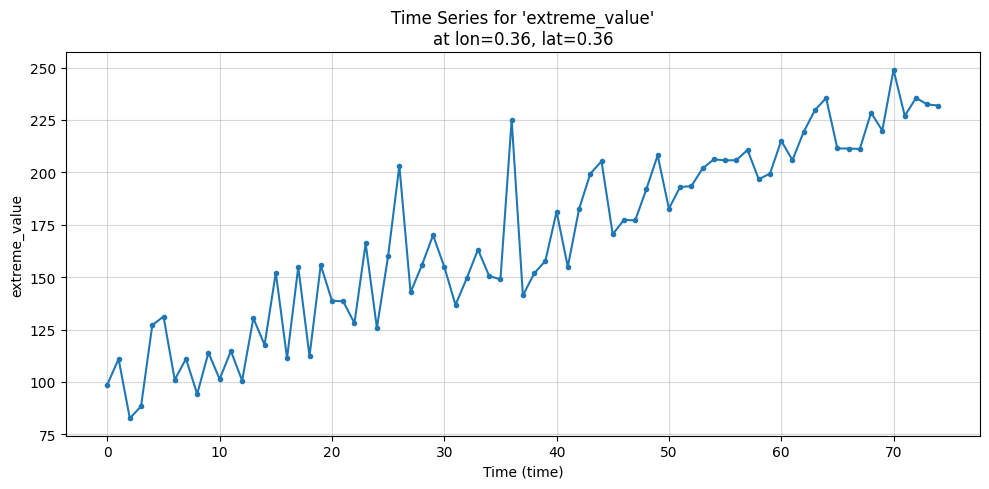


Plotting spatial map for time index (time=0)...


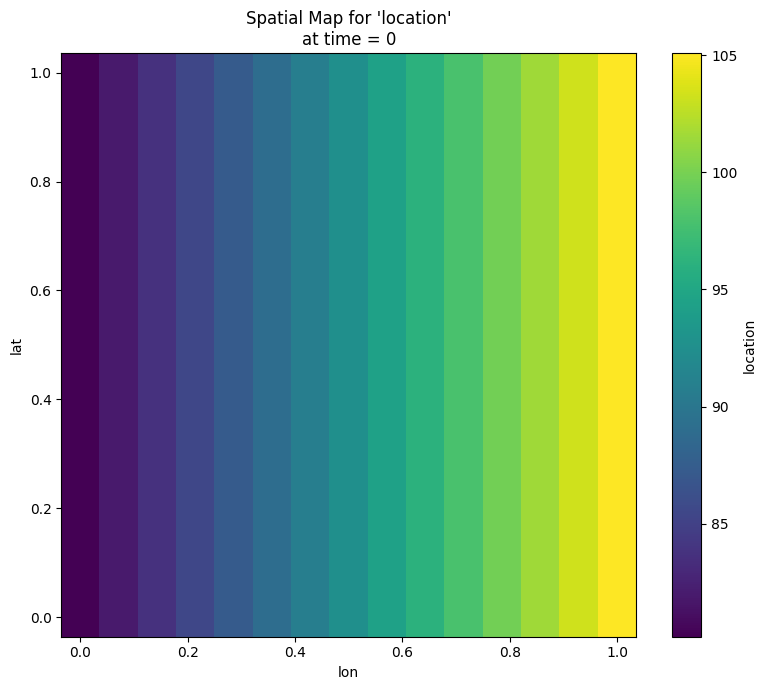

<xarray.Dataset> Size: 473kB
Dimensions:        (lon: 15, lat: 15, time: 75)
Coordinates:
  * lon            (lon) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * lat            (lat) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0
  * time           (time) int32 300B 0 1 2 3 4 5 6 7 ... 67 68 69 70 71 72 73 74
Data variables:
    extreme_value  (lon, lat, time) float64 135kB 89.28 79.24 ... 259.2 244.3
    location       (lon, lat, time) float64 135kB 80.17 82.17 ... 251.1 253.1
    scale          (lon, lat, time) int32 68kB 11 11 11 11 11 ... 11 11 11 11 11
    shape          (lon, lat, time) float64 135kB 0.1 0.1 0.1 ... 0.1 0.1 0.1
Attributes:
    creation_timestamp:     2025-04-15T16:02:57.724169+00:00
    source:                 Generated by create_gev_nonstationary
    grid_type:              normalized spatial coordinates (0-1), integer tim...
    dependencies:           Spatio-temporal dependence via user-defined trend...
    eval_security_warning:  Trend functions evaluated using eval(). Use with ...

In [100]:
location_param = 68
scale_param = 11
shape_param = 0.1

# 2. Specify grid dimensions
x_dim_size = 15
y_dim_size = 15
t_dim_size = 75

def generate_linear_simple_trend(
    seed: int = 2,
    coeff_range: List[Tuple[float, float]] =  [(-30.0, -15.0), (15.0, 30.0)],
    intercept_range:  Tuple[float, float] = (-30, 30)
) -> str:
    rng = np.random.default_rng(seed)
    variable = rng.choice(['x', 'y'])
    chosen_range_index = rng.integers(len(coeff_range))
    coeff = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])

    chosen_range_index = rng.integers(len(intercept_range))
    min_val, max_val = intercept_range
    # 2. Sample uniformly from the chosen range
    intercept = rng.uniform(min_val, max_val)
    return f"{coeff:.3f} * {variable} {intercept:+.3f}" # :+ adds sign

def generate_linear_non_isotropic_trend(
    seed: int = 42,
    coeff_range: List[Tuple[float, float]]=  [(-30.0, -15.0), (15.0, 30.0)],
    intercept_range: Tuple[float, float] = (-0.5, 0.5)
) -> str:
    """
    Generates a linear trend string depending on both 'x' AND 'y'.
    Formula: ax + by + c
    The intercept 'c' is chosen from one of the provided ranges.

    Args:
        seed: Seed for the random number generator.
        coeff_range: Tuple (min, max) for both x and y coefficients (a, b).
        intercept_ranges: A list of tuples [(min1, max1), (min2, max2), ...].
                          The intercept 'c' will be sampled uniformly from one
                          of these ranges, chosen randomly.

    Returns:
        A trend string like "1.234 * x - 0.567 * y + 25.111".
    """
    rng = np.random.default_rng(seed)
    chosen_range_index = rng.integers(len(coeff_range))
    coeff_x = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])
    coeff_y = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])

    chosen_range_index = rng.integers(len(intercept_range))
    min_val, max_val = intercept_range
    intercept = rng.uniform(min_val, max_val)

    return f"{coeff_x:.3f} * x {coeff_y:+.3f} * y {intercept:+.3f}"

def generate_polynomial_interaction_trend(
    seed: int = 42,
    max_degree: int = 3, # Max total degree (e.g., 2 allows x, y, x*y, x**2, y**2)
    term_prob: float = 0.7, # Probability of including any potential term
    coeff_range: Tuple[float, float] = [(-30.0, -15.0), (15.0, 30.0)]
) -> str:
    """
    Generates a polynomial trend string including interaction terms (like x*y).

    Creates a polynomial by randomly selecting terms up to a max_degree,
    where each term involves powers of x and y (e.g., c, ax, by, dx*y, ex**2, ...).

    Args:
        seed: Seed for the random number generator.
        max_degree: The maximum total degree for any term (deg_x + deg_y <= max_degree).
                    Must be >= 0.
        term_prob: Probability (0 to 1) that any potential valid term (up to max_degree)
                   is included in the final polynomial. Controls complexity/sparsity.
        coeff_range: Tuple (min, max) for the random coefficient of each term.

    Returns:
        A trend string representing the polynomial, e.g.,
        "0.500 + 1.200 * x - 0.800 * y + 1.100 * x * y - 0.300 * x**2".
        Returns "0.0" if no terms are selected.
    """
    
    if max_degree < 0:
        raise ValueError("max_degree must be non-negative")

    rng = np.random.default_rng(seed)
    chosen_range_index = rng.integers(len(coeff_range))
    terms_list = []

    for deg_x in range(max_degree + 1):
        for deg_y in range(max_degree - deg_x + 1):
            # Consider including this term (x**deg_x * y**deg_y)
            if rng.random() < term_prob:
                # Generate coefficient
                # Make constant term (0,0) less likely to be zero if it's selected
                if deg_x == 0 and deg_y == 0:
                     coeff = rng.uniform(coeff_range[chosen_range_index][0] / 2.0, coeff_range[chosen_range_index][1] / 2.0) # Smaller range for constant
                     if abs(coeff) < 1e-6 : coeff = 0.1 # Avoid tiny constant if possible
                else:
                     coeff = rng.uniform(coeff_range[chosen_range_index][0], coeff_range[chosen_range_index][1])


                # Skip term if coefficient is effectively zero (unless it's the constant)
                if abs(coeff) < 1e-6 and not (deg_x == 0 and deg_y == 0):
                    continue

                # --- Construct the term string ---
                term_parts = []
                # X part
                if deg_x == 1:
                    term_parts.append("x")
                elif deg_x > 1:
                    term_parts.append(f"x**{deg_x}")

                # Y part
                if deg_y == 1:
                    term_parts.append("y")
                elif deg_y > 1:
                    term_parts.append(f"y**{deg_y}")

                # Combine parts with coefficient
                if not term_parts: # Constant term (deg_x=0, deg_y=0)
                    term_string = f"{coeff:+.3f}"
                else:
                    # :+ ensures sign, .3f formats float, strip removes trailing space if needed
                    term_string = f"{coeff:+.3f} * {' * '.join(term_parts)}"

                terms_list.append(term_string)

    # --- Combine terms into final string ---
    if not terms_list:
        return "0.0" # Return "0.0" if no terms were selected

    # Join the strings. The :+.3f format ensures a sign for all terms.
    full_trend = " ".join(terms_list)
    # Remove leading '+' if the first term was positive.
    if full_trend.startswith('+'):
        full_trend = full_trend[1:].strip()
    elif full_trend.startswith('-'):
         full_trend = full_trend.strip() # Keep leading '-' but remove potential extra space

    # Handle case where the only term was a near-zero constant that formatted to "+0.000" or "-0.000"
    if full_trend == "0.000" or full_trend == "-0.000":
         return "0.0"
    # Handle case where only term selected was effectively zero coefficient non-constant term
    if not full_trend:
         return "0.0"


    return full_trend

def generate_multi_blob(
    num_blobs : int = 2,
    seed : int = 42,
    amplitude_range: Tuple[float, float] = (49, 50),
    center_range: Tuple[float, float] = (0, 1), # Avoid edges slightly
    decay_range: Tuple[float, float] = (30, 80.0),
    anisotropy_ratio_range: Tuple[float, float] = (1.5, 5.0),
    anisotropy_prob: float = 0.7
) -> str:
    """
    Generates a trend string representing the sum of multiple Gaussian blobs.

    Blob parameters (center, amplitude, decay, anisotropy) are randomized
    based on the provided seed.

    Args:
        num_blobs: The number of blobs to generate.
        seed: Seed for the random number generator for reproducibility.
        amplitude_range: Tuple (min, max) for the peak amplitude (A).
        center_range: Tuple (min, max) for the x and y center coordinates (cx, cy).
        decay_range: Tuple (min, max) for the base decay parameter (B or B_base).
                     Higher values mean narrower blobs.
        anisotropy_ratio_range: Tuple (min, max) for the ratio between the
                                stronger and weaker decay axes (Bx/By or By/Bx)
                                if the blob is anisotropic. Must be >= 1.
        anisotropy_prob: Probability (0 to 1) that any given blob will be
                         anisotropic.

    Returns:
        A string representing the mathematical function for the sum of blobs,
        suitable for use in `create_gev_nonstationary` trend functions.
    """
    if num_blobs <= 0:
        return "0.0" # Return a constant zero trend if no blobs requested

    rng = np.random.default_rng(seed)
    blob_strings = []

    for _ in range(num_blobs):
        # Random parameters for this blob
        cx = rng.uniform(center_range[0], center_range[1])
        cy = rng.uniform(center_range[0], center_range[1])
        A = rng.uniform(amplitude_range[0], amplitude_range[1])
        B_base = rng.uniform(decay_range[0], decay_range[1])

        is_anisotropic = rng.random() < anisotropy_prob

        if is_anisotropic and num_blobs > 0 : # Ensure ratio > 1 for anisotropy
             anisotropy_ratio = rng.uniform(anisotropy_ratio_range[0], anisotropy_ratio_range[1])
             stronger_axis = rng.choice(['x', 'y'])

             if stronger_axis == 'x':
                 Bx = B_base * anisotropy_ratio
                 By = B_base
             else: # Stronger along y
                 Bx = B_base
                 By = B_base * anisotropy_ratio

             # Format anisotropic blob string
             blob_str = (f"{A:+.3f} * np.exp(-({Bx:.3f} * (x - {cx:.3f})**2 + "
                         f"{By:.3f} * (y - {cy:.3f})**2))")
        else:
             # Format isotropic blob string (Bx = By = B_base)
              blob_str = (f"{A:+.3f} * np.exp(-{B_base:.3f} * ("
                          f"(x - {cx:.3f})**2 + (y - {cy:.3f})**2))")

        blob_strings.append(blob_str)

    # Join the strings. The :+.3f format ensures a sign for all terms.
    # We remove the leading '+' if the first term was positive.
    full_trend = " ".join(blob_strings)
    if full_trend.startswith('+'):
        full_trend = full_trend[1:].strip() # Remove leading '+' and space
    elif full_trend.startswith('-'):
        full_trend = full_trend.strip() # Keep leading '-' but remove space

    # Handle case where all amplitudes might be zero (unlikely but possible)
    if not full_trend:
        return "0.0"

    return full_trend

real_func = generate_linear_simple_trend(seed=37)
print(real_func)
gev_dataset_dimless = create_gev_nonstationary(
    loc_trend_func=real_func + ' + 2 * t',
    loc=location_param,
    scale=scale_param,
    shape=shape_param,
    num_x=x_dim_size,
    num_y=y_dim_size,
    num_t=t_dim_size
)

# 4. Inspect the dataset (optional)
print("Generated xarray Dataset (Dimensionless Coordinates):")
print(gev_dataset_dimless)

# 5. Use the new plotting functions
# --- Plot time series at a specific point (e.g., x=10, y=15) ---
plot_x_index = 5
plot_y_index = 5
print(f"\nPlotting time series for point (lon={plot_x_index}, lat={plot_y_index})...")
plot_time(gev_dataset_dimless, lon_index=plot_x_index, lat_index=plot_y_index)

# --- Plot spatial map at a specific time (e.g., t=0) ---
plot_t_index = 0
print(f"\nPlotting spatial map for time index (time={plot_t_index})...")
plot_map(gev_dataset_dimless, t_index=plot_t_index,var_name='location')


gev_dataset_dimless

Fitting

In [97]:
#print(gev_dataset_dimless.attrs["trend_slope_b1"])
endog, exog, mdt = xarray_to_endog_exog(ds = gev_dataset_dimless["extreme_value"].to_dataset(),endog_var="extreme_value",include_time_coords=True, include_space_coords=True)
print(mdt)
exog.shape

{'t': 75, 'n_lat': 30, 'n_lon': 30, 's': 900, 'covariates': [{'name': 'lat', 'original_dims': ('lat',), 'is_coord': True}, {'name': 'lon', 'original_dims': ('lon',), 'is_coord': True}, {'name': 'time', 'original_dims': ('time',), 'is_coord': True}]}


(75, 3, 900)

In [98]:
print(exog.shape)
afit = GEVSample(endog=endog,exog={"location" : exog}).fit(fit_method='MLE')
print(afit)

(75, 3, 900)

          EVT Results Summary       
Data dimensions : (75, 900)
AIC: 544271.80  
BIC: 544285.70  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 80.3123      | 634.81       | 0.0000       | (80.0644, 80.5603)        | ***      |
| μ_1        | -0.2887      | -2.16        | 0.0310       | (-0.5510, -0.0265)        | *        |
| μ_2        | 24.8680      | 185.31       | 0.0000       | (24.6050, 25.1310)        | ***      |
| μ_3        | 2.0007       | 1077.62      | 0.0000       | (1.9971, 2.0044)          | ***      |
| σ_0        | 10.9859      | 306.73       | 0.0000       | (10.9157, 11.0561)        | ***      |
| ξ_0        | 0.1005       | 35.17        | 0.0000       | (0.0949, 0.1061)          | ***   

In [11]:
def reconstruct_xarray_from_flat(
    prediction_params_flat: np.ndarray, 
    mdt: Dict[str, Any],
    original_ds: xr.Dataset
) -> xr.Dataset:
    """
    Reconstructs an xarray Dataset with GEV parameters (loc, scale, shape)
    from a flattened prediction array (parameters, time, space).

    Assumes the input array corresponds to loc, scale, shape in order along
    the first dimension.
    Reverses the flattening performed by xarray_to_endog_exog
    (which uses stack(space=('lat', 'lon'))).

    Args:
        prediction_params_flat: The 3D NumPy array prediction with shape
                                (3, T, S) for [loc, scale, shape], where
                                S = N_lat * N_lon.
        mdt: Metadata dictionary containing 't', 'n_lat', 'n_lon', 's'.
        original_ds: The original xarray Dataset from which the data was
                     flattened. Used to retrieve coordinates and ensure consistency.

    Returns:
        An xarray Dataset containing three data variables ('prediction_loc',
        'prediction_scale', 'prediction_shape'), each with dimensions
        ('lon', 'lat', 'time').

    Raises:
        ValueError: If shapes or metadata are inconsistent.
        TypeError: If prediction_params_flat is not a NumPy array.
    """
    # 1. Extract Dimensions from metadata
    try:
        T = mdt['t']
        N_lat = mdt['n_lat']
        N_lon = mdt['n_lon']
        S = mdt['s'] # Total spatial points
    except KeyError as e:
        raise ValueError(f"Metadata dictionary 'mdt' is missing required key: {e}")

    # --- Simplified Input Validation ---
    if not isinstance(prediction_params_flat, np.ndarray):
        raise TypeError("prediction_params_flat must be a NumPy array.")

    expected_shape_3d = (3, T, S)
    if prediction_params_flat.shape != expected_shape_3d:
            # Check if S in metadata was inconsistent but dims otherwise match
            if prediction_params_flat.shape[0] == 3 and \
               prediction_params_flat.shape[1] == T and \
               prediction_params_flat.shape[2] == N_lat * N_lon:
                 warnings.warn(f"Metadata inconsistency: mdt['s'] ({S}) != N_lat ({N_lat}) * N_lon ({N_lon}). "
                               f"Input array shape ({prediction_params_flat.shape}) matches (3, T, N_lat*N_lon). "
                               f"Proceeding by correcting S.", UserWarning)
                 S = N_lat * N_lon # Correct S based on dims
            else:
                 # Shape mismatch is real
                 raise ValueError(f"Input NumPy array prediction_params_flat has incorrect shape {prediction_params_flat.shape}. "
                                  f"Expected {expected_shape_3d} based on metadata (parameters, time, space).")
    # --- End Input Validation ---


    # 3. Get Coordinates from original dataset
    try:
        lon_coord_name = 'lon'
        lat_coord_name = 'lat'
        time_coord_name = 'time'

        lon_coords = original_ds[lon_coord_name]
        lat_coords = original_ds[lat_coord_name]
        time_coords = original_ds[time_coord_name]

        # Verify coordinate lengths match metadata dimensions
        if len(lon_coords) != N_lon:
            raise ValueError(f"Original dataset '{lon_coord_name}' coord length ({len(lon_coords)}) "
                             f"doesn't match metadata n_lon ({N_lon})")
        if len(lat_coords) != N_lat:
            raise ValueError(f"Original dataset '{lat_coord_name}' coord length ({len(lat_coords)}) "
                             f"doesn't match metadata n_lat ({N_lat})")
        if len(time_coords) != T:
             if len(time_coords) < T :
                  raise ValueError(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is less than metadata T ({T})")
             elif len(time_coords) > T:
                  warnings.warn(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is greater than metadata T ({T}). Using the first {T} time coordinates.", UserWarning)
                  time_coords = time_coords[:T]

    except KeyError as e:
        raise ValueError(f"Original dataset 'original_ds' is missing expected coordinate: {e}")

    # --- Reconstruct each parameter ---
    reconstructed_params = {}
    param_names = ['prediction_loc', 'prediction_scale', 'prediction_shape']

    for i, param_name in enumerate(param_names):
        # Extract the flattened data for this parameter: shape (T, S)
        param_flat = prediction_params_flat[i, :, :]

        # 4. Transpose and Reshape
        # Input shape (T, S) -> Transpose to (S, T)
        # Reshape S (where lon varied fastest) back to (N_lat, N_lon)
        # Resulting shape before final transpose: (N_lat, N_lon, T)
        try:
            reshaped_data_lat_lon_time = param_flat.T.reshape((N_lat, N_lon, T))
        except ValueError as e:
            raise ValueError(f"Reshaping failed for parameter '{param_name}' (to N_lat, N_lon, T). "
                             f"Check consistency. Original error: {e}")

        # 5. Create intermediate DataArray with (lat, lon, time) order
        param_da_intermediate = xr.DataArray(
            data=reshaped_data_lat_lon_time,
            coords=[lat_coords, lon_coords, time_coords],
            dims=[lat_coord_name, lon_coord_name, time_coord_name],
            name=param_name
        )

        # 6. Transpose to final desired order ('lon', 'lat', 'time')
        param_da_final = param_da_intermediate.transpose(lon_coord_name, lat_coord_name, time_coord_name)

        reconstructed_params[param_name] = param_da_final

    # 7. Create final Dataset
    reconstructed_ds = xr.Dataset(reconstructed_params)

    return reconstructed_ds

In [66]:
test = reconstruct_xarray_from_flat(np.stack(afit.gev_params,axis=0),mdt,gev_dataset_dimless)
test

<xarray.Dataset> Size: 406kB
Dimensions:           (lat: 15, lon: 15, time: 75)
Coordinates:
  * lat               (lat) float64 120B 0.0 0.07143 0.1429 ... 0.9286 1.0
  * lon               (lon) float64 120B 0.0 0.07143 0.1429 ... 0.9286 1.0
  * time              (time) int32 300B 0 1 2 3 4 5 6 7 ... 68 69 70 71 72 73 74
Data variables:
    prediction_loc    (lon, lat, time) float64 135kB 80.01 83.01 ... 324.4 327.4
    prediction_scale  (lon, lat, time) float64 135kB 10.06 10.06 ... 10.06 10.06
    prediction_shape  (lon, lat, time) float64 135kB 0.09994 0.09994 ... 0.09994


Plotting spatial map for time index (time=0)...


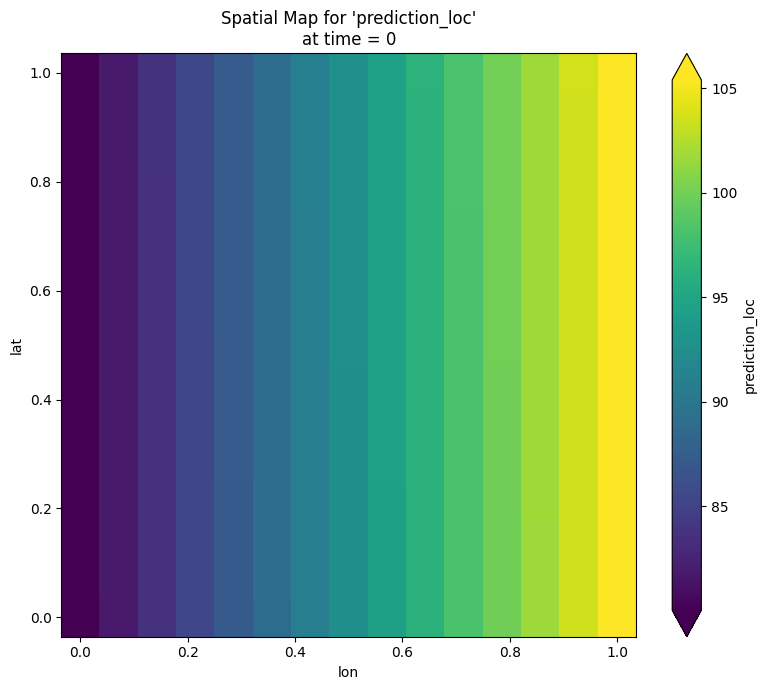

In [67]:
plot_t_index = 0
print(f"\nPlotting spatial map for time index (time={plot_t_index})...")
plot_map(test, t_index=plot_t_index,var_name="prediction_loc")

Bias, Variance, MSE

In [12]:
def calculate_parameter_metrics(
    fit_ds: xr.Dataset,
    ground_truth_ds: xr.Dataset,
    param_mapping: Dict[str, str] = {
        'location': 'prediction_loc',
        'scale': 'prediction_scale',
        'shape': 'prediction_shape'
    }
) -> Dict[str, Dict[str, float]]:
    """
    Calculates Bias, Variance of Error, MSE, and RMSE by comparing
    fitted GEV parameters against true GEV parameters.

    Args:
        fit_ds: Dataset containing the fitted parameters (e.g., 'prediction_loc').
                Must have dimensions ('lon', 'lat', 'time') or compatible.
        ground_truth_ds: Dataset containing the true parameters (e.g., 'location').
                         Must have dimensions ('lon', 'lat', 'time') or compatible.
        param_mapping: Dictionary mapping true parameter names (keys) to the
                       corresponding fitted parameter variable names (values)
                       in the input datasets.

    Returns:
        A dictionary where keys are the true parameter names ('location', 'scale',
        'shape') and values are dictionaries containing the calculated scalar
        metrics ('bias', 'variance_of_error', 'mse', 'rmse') for that parameter.

    Raises:
        ValueError: If required variables are missing or datasets are incompatible.
        KeyError: If parameter names in mapping are not found.
    """
    results = {}
    required_dims = {'lon', 'lat', 'time'} # Assuming these standard dims

    for true_name, fit_name in param_mapping.items():
        # --- Check variables exist ---
        if fit_name not in fit_ds:
            raise KeyError(f"Fitted variable '{fit_name}' not found in fit_ds.")
        if true_name not in ground_truth_ds:
            raise KeyError(f"True variable '{true_name}' not found in ground_truth_ds.")

        fit_da = fit_ds[fit_name]
        true_da = ground_truth_ds[true_name]

        # --- Check dimensions (optional but recommended) ---
        if not required_dims.issubset(fit_da.dims):
             warnings.warn(f"Fitted variable '{fit_name}' missing expected dims {required_dims}. Found {fit_da.dims}")
        if not required_dims.issubset(true_da.dims):
             warnings.warn(f"True variable '{true_name}' missing expected dims {required_dims}. Found {true_da.dims}")


        # --- Align and Calculate Error ---
        try:
            # Align datasets - crucial if coordinates might differ slightly in order/precision
            # Using inner join to ensure only comparable points are used
            fit_aligned, true_aligned = xr.align(fit_da, true_da, join="inner")

            # Ensure float for calculations
            fit_aligned = fit_aligned.astype(float)
            true_aligned = true_aligned.astype(float)

            if fit_aligned.size == 0:
                 raise ValueError(f"Alignment resulted in zero overlapping points for parameter '{true_name}'. Check coordinates.")

            error_da = fit_aligned - true_aligned

        except Exception as e:
            raise ValueError(f"Failed to align or subtract parameters '{fit_name}' and '{true_name}'. Check dimensions and coordinates. Original error: {e}")

        # --- Calculate Metrics ---
        # Average over all dimensions to get scalar values
        bias = float(error_da.mean().item())
        mse = float((error_da**2).mean().item())
        rmse = np.sqrt(mse)
        # Calculate variance of the parameter error
        variance_of_error = float(((error_da - bias)**2).mean().item())
        # Verification: variance_of_error should be close to mse - bias**2
        #assert np.isclose(variance_of_error, mse - bias**2)

        results[true_name] = {
            'bias': bias,
            'variance_of_error': variance_of_error,
            'mse': mse,
            'rmse': rmse,
        }

    return results

BIG SIM 

1] Trend in X

In [40]:
real_func = generate_linear_simple_trend(seed=37)
gev_ds = create_gev_nonstationary(
    loc_trend_func=real_func + '-20 * t',
    loc=location_param,
    scale=scale_param,
    shape=shape_param,
    num_x=x_dim_size,
    num_y=y_dim_size,
    num_t=t_dim_size
)
afit = GEVSample(endog=endog,exog={"location" : exog}).fit(fit_method='MLE')
pred_ds = reconstruct_xarray_from_flat(np.stack(afit.gev_params,axis=0),mdt,gev_dataset_dimless)
parameter_metrics = calculate_parameter_metrics(pred_ds, gev_ds)

C:\Users\paulusr\AppData\Local\Temp\ipykernel_15352\400599288.py:186: UserWarning: Evaluating potentially unsafe string for 'loc': 24.925 * x +12.168-20 * t...
  warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",


In [101]:
num_simulations = 3
all_metrics_list = []
rng = np.random.default_rng() # Random number generator for the offset

for i in range(num_simulations):
    current_seed = i # Use a different seed for the spatial trend each time
    # Generate a random constant value for the 't' component replacement
    random_t_offset = rng.uniform(0,30)

    print(f"\n--- Simulation Run {i+1}/{num_simulations} (seed={current_seed}, t_tred={random_t_offset:.2f}) ---")
    try:
        # 1. Generate Base Spatial Trend Function (randomized by seed)
        trend_info = generate_linear_simple_trend(seed=i)
        # 2. Construct the location trend with the random offset
        current_loc_trend_func = trend_info + f" +  3 * t"
        # 3. Generate Ground Truth Dataset with the modified trend
        # Note: seed might still be used inside create_gev_nonstationary for GEV sampling
        gev_ds = create_gev_nonstationary(
            loc_trend_func=current_loc_trend_func,
            loc=location_param,
            shape=shape_param,
            scale=scale_param,
            num_x=x_dim_size,
            num_y=y_dim_size,
            num_t=t_dim_size,
            seed=i # Pass seed if GEV sampling uses it
        )

        # 4. Flatten Data for Fitting (using YOUR functions/placeholders)
        # Adapt this section based on your actual workflow and variable names
        endog, exog, mdt = xarray_to_endog_exog(ds = gev_ds["extreme_value"].to_dataset(),endog_var="extreme_value",include_time_coords=True, include_space_coords=True)
        # Prepare exog for GEVSample fitting based on its requirements
        # Example: Maybe no exogenous variables are needed now?

        # 5. Fit Model (using YOUR GEVSample class)
        afit = GEVSample(endog=endog, exog={"location" : exog}).fit(fit_method='MLE')
        print(afit)
        # 7. Reconstruct Fitted Dataset (using YOUR function)
        pred_ds = reconstruct_xarray_from_flat(
             prediction_params_flat=np.stack(afit.gev_params, axis=0),
             mdt=mdt,
             original_ds=gev_ds # Pass original dataset for coords
        )

        # 8. Calculate Metrics for this run (using YOUR function)
        parameter_metrics = calculate_parameter_metrics(pred_ds, gev_ds)
        all_metrics_list.append(parameter_metrics)

        # Optional: print progress
        # if (i + 1) % 10 == 0:
        #     print(f"   Completed run {i+1}/{num_simulations}")

    except Exception as e:
        print(f"!!! Error in simulation run {i+1} (seed={current_seed}): {e}")
        # Decide how to handle errors: skip run, append None, etc.
        # Skipping the run for averaging:
        # all_metrics_list.append(None) # Or simply don't append

# --- Average Metrics ---
print(f"\n--- Averaging Metrics over {len(all_metrics_list)} successful runs ---")
if not all_metrics_list:
    print("No simulations were run or produced results.")
else:
    # Initialize dictionaries to store sums and counts for averaging
    metric_sums: Dict[str, Dict[str, float]] = {}
    metric_counts: Dict[str, Dict[str, int]] = {}
    param_types = ['location', 'scale', 'shape']
    # Assume these metric names are consistently produced by calculate_parameter_metrics
    metric_names = ['bias', 'variance_of_error', 'mse', 'rmse']

    # Initialize sums and counts to zero
    for param in param_types:
        metric_sums[param] = {metric: 0.0 for metric in metric_names}
        metric_counts[param] = {metric: 0 for metric in metric_names}

    # Accumulate sums and counts from valid runs
    num_valid_runs = 0
    for run_metrics in all_metrics_list:
        if run_metrics is None: # Skip failed runs if None was appended
            continue
        num_valid_runs += 1
        for param in param_types:
            if param in run_metrics: # Check if param results exist for this run
                for metric in metric_names:
                    # Check if metric exists and is a valid number
                    if metric in run_metrics[param] and isinstance(run_metrics[param][metric], (int, float)) and not np.isnan(run_metrics[param][metric]):
                        metric_sums[param][metric] += run_metrics[param][metric]
                        metric_counts[param][metric] += 1

    if num_valid_runs == 0:
         print("No simulation runs completed successfully or produced valid metrics.")
    else:
         # Calculate averages
         averaged_metrics: Dict[str, Dict[str, float]] = {}
         for param in param_types:
             averaged_metrics[param] = {}
             for metric in metric_names:
                 if metric_counts[param][metric] > 0:
                     # Calculate average only if there were valid counts
                     averaged_metrics[param][metric] = metric_sums[param][metric] / metric_counts[param][metric]
                 else:
                     # Assign NaN if no valid data points were found for this metric/param
                     averaged_metrics[param][metric] = np.nan

         # --- Print Averaged Results ---
         print("\n--- Averaged Parameter Metrics ---")
         for param, metrics in averaged_metrics.items():
             print(f"\nParameter: {param}")
             # Print in a consistent order
             for metric_name in ['bias', 'variance_of_error', 'mse', 'rmse']:
                 if metric_name in metrics:
                      value = metrics[metric_name]
                      print(f"  Avg. {metric_name:<20}: {value:.6f}")
                 else:
                      # Should not happen with this logic unless metric_names is wrong
                      print(f"  Avg. {metric_name:<20}: Not Calculated")



--- Simulation Run 1/3 (seed=0, t_tred=14.32) ---


C:\Users\paulusr\AppData\Local\Temp\ipykernel_15352\400599288.py:186: UserWarning: Evaluating potentially unsafe string for 'loc': 19.047 * y -29.008 +  3 * t...
  warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",



          EVT Results Summary       
Data dimensions : (75, 225)
AIC: 136297.60  
BIC: 136311.50  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 38.8156      | 154.19       | 0.0000       | (38.3222, 39.3090)        | ***      |
| μ_1        | 19.1540      | 73.02        | 0.0000       | (18.6399, 19.6681)        | ***      |
| μ_2        | 0.4471       | 1.70         | 0.0883       | (-0.0671, 0.9613)         |          |
| μ_3        | 2.9998       | 801.10       | 0.0000       | (2.9925, 3.0072)          | ***      |
| σ_0        | 11.0634      | 153.66       | 0.0000       | (10.9223, 11.2046)        | ***      |
| ξ_0        | 0.0999       | 17.63        | 0.0000       | (0.0888, 0.1111)          | ***      |
+-------

C:\Users\paulusr\AppData\Local\Temp\ipykernel_15352\400599288.py:186: UserWarning: Evaluating potentially unsafe string for 'loc': 29.257 * x +26.919 +  3 * t...
  warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",



          EVT Results Summary       
Data dimensions : (75, 225)
AIC: 136071.68  
BIC: 136085.59  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 95.0467      | 380.55       | 0.0000       | (94.5572, 95.5362)        | ***      |
| μ_1        | -0.1139      | -0.44        | 0.6633       | (-0.6267, 0.3989)         |          |
| μ_2        | 28.8779      | 111.22       | 0.0000       | (28.3690, 29.3868)        | ***      |
| μ_3        | 3.0020       | 811.33       | 0.0000       | (2.9947, 3.0092)          | ***      |
| σ_0        | 10.9901      | 153.10       | 0.0000       | (10.8494, 11.1308)        | ***      |
| ξ_0        | 0.0979       | 16.86        | 0.0000       | (0.0865, 0.1093)          | ***      |
+-------

C:\Users\paulusr\AppData\Local\Temp\ipykernel_15352\400599288.py:186: UserWarning: Evaluating potentially unsafe string for 'loc': -25.523 * y -24.485 +  3 * t...
  warnings.warn(f"Evaluating potentially unsafe string for '{param_name}': {trend_func_str[:100]}...",



          EVT Results Summary       
Data dimensions : (75, 225)
AIC: 136397.10  
BIC: 136411.00  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 43.4977      | 173.47       | 0.0000       | (43.0062, 43.9892)        | ***      |
| μ_1        | -25.7350     | -97.89       | 0.0000       | (-26.2503, -25.2197)      | ***      |
| μ_2        | 0.2050       | 0.78         | 0.4368       | (-0.3118, 0.7219)         |          |
| μ_3        | 3.0004       | 803.62       | 0.0000       | (2.9931, 3.0077)          | ***      |
| σ_0        | 11.0600      | 152.59       | 0.0000       | (10.9179, 11.2021)        | ***      |
| ξ_0        | 0.1044       | 17.96        | 0.0000       | (0.0930, 0.1158)          | ***      |
+-------